# How to approach a 2D Medical Images(Chest-X-Rays) classification problem using Pytorch and MONAI
> In this blog, I will demonstrate how to approach the classification problems of 2D Medical images (Chest X-rays). You will get familiar with various preprocessing+post processing, data augmentation techniques, tips, and dead-ends in Chest X rays classification.    <br />Keywords- Medical Imaging, Deep Learning, Pytorch, MONAI, Chest X-Ray, Pydicom, Pneumonia-COVID-Classifciation, tutorial, MICCAI

- toc: true 
- badges: true
- comments: true
- categories: [tutorial]
- image: images/blog_3.jpg
- author: Akansh Maurya

# About

**Knowledge is not the power, implementation is power**. ~ **Garrison Wynn.** 

You have completed a course in Machine Learning and Deep learning, and you are excited to apply your newly earned AI wisdom to the field of Healthcare and Medical images, but the only obstacle is that you don't know which tools you should use? How should you approach the problem and write the code? And the bigger question **How should I move from theory to practice?**

If these are your worries, then you are at the right place. This blog is all about giving you the right tools to implement your knowledge and feel **powerful**. Specifically, in this blog, we will learn how to use the Deep Learning method to classify two-dimensional (2D) Medical images, Chest X-rays into three classes COVID-19, Pneumonia, and Normal. We will be using two awesome python libraries Pytorch and MONAI. We will be learning Pre/Post-processing techniques, Data Augmentation methods. We will also review the concepts of the weighted cross-entropy loss function, learning rate scheduler, AUC-ROC metric, DenseNet, efficientNet, and so on.



**Isn't that exciting?**


![](https://github.com/akansh12/confession-of-a-coding-freak/blob/master/_notebooks/my_icons/title_diagram_blog_3.png?raw=1)


Consider this blog more like a tutorial that will help you to get familiar with the pipeline for training-validationg-testing for medical imaging(CXR) files. As this blog is written using [fastpages](https://github.com/fastai/fastpages), you can run this whole tutorial and associated code as a Jupyter notebook.


# Dataset: Chest XR COVID-19 detection Challenge

The Coronavirus disease 2019 (COVID-19) pandemic remains a worldwide concern. In India alone, over 30 million people were infected and more than 400 thousand have lost their lives. Early diagnosis and separation of possibly infectious subjects is a significant step to fight against COVID-19, this can help in immediate treatment and care.he gold standard screening approach for identifying the coronavirus is reverse transcription-polymerase chain reaction (RT-PCR). Other alternative screening methods include the use of computed tomography (CT) and **Chest X-rays** that can show visual indicators of COVID-19 viral infections and other diseases like Pneumonia.

One of the advantages of these medical imaging methods is that they can help in the detection of the severity of the disease while tests like RT-PCR only indicate the presence of the infection. Medical imaging methods can also be used to identify the recovery status of a patient. 


Interpretation of chest X-rays requires an expert physician and with the advent of the COVID-19 pandemic, a practitioner can misclassify the X-Rays easily. Computer-aided methods that are fast and reliable can prove to be effective and help doctors for better understanding and classification. Let us use or knowledge of AI to help radiologist.

## What is the challenge?

[Chest XR COVID-19 detection Challenge](https://cxr-covid19.grand-challenge.org/CXR-COVID19/) was hosted on grand-challenge.org in year 2021 and the challenge aims to develop a multiclass classification algorithm capable of detecting COVID-19 in Chest X-ray images. The dataset contains 3 image classes: COVID-19, Pneumonia and Normal (healthy). 
![](my_icons/COVID-Challenge.jpg "Credit:https://cxr-covid19.grand-challenge.org")

## Getting the Dataset

The dataset is available on google drive. It has a size of 3.61GB. All the CXR are either .jpeg, .jpg, .png files. We can download and extract the dataset using the following code. Please comment below, if you face any problem in downloading the dataset.

In [1]:
#hide
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Data Download
!gdown --id 12kvHaeYQVGtdcsaxtsGu8ft-OuY-BKya
import zipfile
import os
os.makedirs("./data")
with zipfile.ZipFile("./CXR_Covid-19_Challenge.zip", 'r') as zip_ref:
    zip_ref.extractall("./data/")

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=12kvHaeYQVGtdcsaxtsGu8ft-OuY-BKya
To: /content/CXR_Covid-19_Challenge.zip
100% 3.61G/3.61G [00:23<00:00, 156MB/s]


Always before jumping to building models, our first task should be understanding the datasets. We need to at least answer the following questions ourselves.

- What is the extension(.npy, .jpg, .jpeg, .dcm) of the files?
- How many training/validation files are present?
- How many classes are present?
- Is the dataset imbalanced?
- If the dataset is images, what are their dimensions? Are these dimensions uniform across all the files?
- etc.

As I mentioned these are the bare minimum questions that one should ask while performing Elementary Data Analysis(EDA). This helps in better preparation of our pipeline from data augmentation, and model selection to post-processing.

## Elementary Data Analysis (EDA)

To answer the above questions lets perform EDA. 

In [3]:
#hide 
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from glob import glob
from PIL import Image

Defining path to training and validation folder and listing the directory present inside them.

In [12]:
train_loc = "./data/train/"
val_loc = "./data/validation/"
print("Name of classes: ", os.listdir(train_loc))
print("Name of classes: ", os.listdir(val_loc))

Name of classes:  ['pneumonia', 'normal', 'covid']
Name of classes:  ['pneumonia', 'normal', 'covid']


Now we can also look the number of Chest X-rays in each folder.

In [20]:
#hide_input
covid_train = os.listdir(os.path.join(train_loc, 'covid'))
normal_train = os.listdir(os.path.join(train_loc, 'normal'))
pneumonia_train = os.listdir(os.path.join(train_loc, 'pneumonia'))

print("Number of images in train Pneumonia: ",len(pneumonia_train))
print("Number of images in train Normal: ",len(normal_train))
print("Number of images in train Covid: ",len(covid_train))
print("-"*40)
covid_val = os.listdir(os.path.join(val_loc, os.listdir(val_loc)[0]))
normal_val = os.listdir(os.path.join(val_loc, os.listdir(val_loc)[1]))
pneumonia_val = os.listdir(os.path.join(val_loc, os.listdir(val_loc)[2]))

print("Number of images in val Pneumonia: ",len(pneumonia_val))
print("Number of images in val Normal: ",len(normal_val))
print("Number of images in val Covid: ",len(covid_val))

Number of images in train Pneumonia:  4273
Number of images in train Normal:  7151
Number of images in train Covid:  6534
----------------------------------------
Number of images in val Pneumonia:  1432
Number of images in val Normal:  1000
Number of images in val Covid:  1000


Often times the files in training data are repeated which can present a false narrative about the size of training data. A simple way to check this is to the number of unique files present inside the folder. If that number matches with our original datasize, then there are no duplicate files.

In [21]:
print(len(np.unique(pneumonia_train)))
print(len(np.unique(normal_train)))
print(len(np.unique(covid_train)))

4273
7151
6534


As you can see the number unique files is same as of original data, there are no repeated file among training dataset. 

> Tip: This is my tip.

Another important aspect is to look if there is no data leakage in training and validation. Data leakage within train-val set leads to deceptive quatification of our model results and accuracy. 

In [22]:
#hide
all_pneumonia = np.concatenate([pneumonia_train, pneumonia_val])
all_covid = np.concatenate([covid_train, covid_val])
all_normal = np.concatenate([normal_train, normal_val])

assert len(np.unique(all_pneumonia)) == len(pneumonia_val) + len(pneumonia_train)
assert len(np.unique(all_normal)) == len(normal_val) + len(normal_train)
assert len(np.unique(all_covid)) == len(covid_val) + len(covid_train)

Finally lets have a visual look at the dataset.

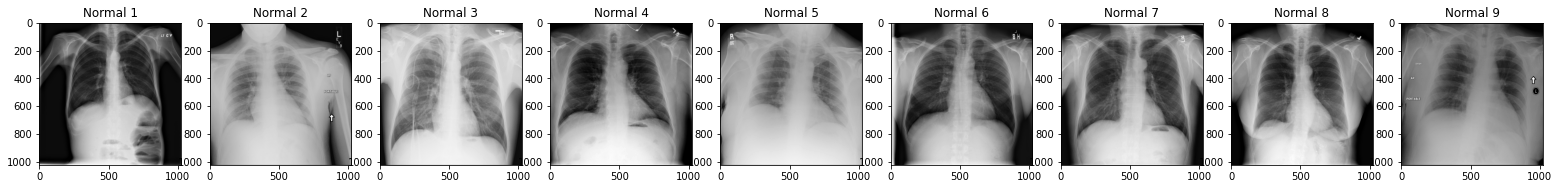

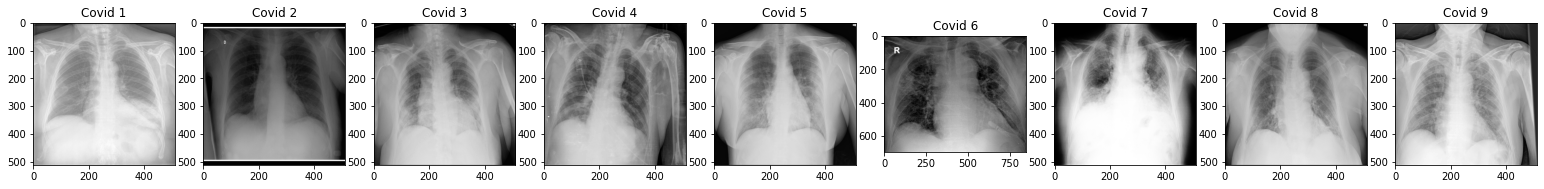

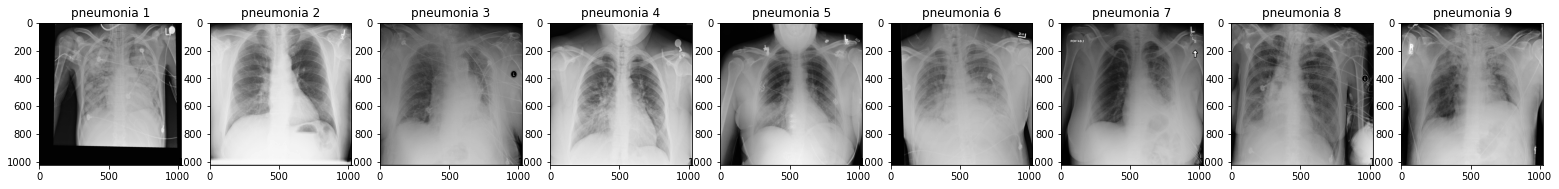

In [24]:
#hide_input
plt.figure(figsize=(30,30)) 
for i in range(1,10):
    plt.subplot(1,10,i,)
    plt.imshow(plt.imread((os.path.join(train_loc+'normal', normal_train[i]))), cmap = 'gray')
    plt.title(f"Normal {i}")
plt.figure(figsize=(30,30)) 
for i in range(1,10):
    plt.subplot(1,10,i,)
    plt.imshow(plt.imread((os.path.join(train_loc+'covid', covid_train[i]))), cmap = 'gray')
    plt.title(f"Covid {i}")
plt.figure(figsize=(30,30)) 
for i in range(1,10):
    plt.subplot(1,10,i,)
    plt.imshow(plt.imread((os.path.join(train_loc+'pneumonia', pneumonia_train[i]))), cmap = 'gray')
    plt.title(f"pneumonia {i}")

As all the Chest X-rays are in .png format, we can check there dimensions. Most of the training models expect input array shape of uniform dimensions. This can be done of defining the following function. In this function we will reading all the images are then appending their dimensions in a pandas dataframe. Later we will be creating the dataframe for each class in train data.

In [25]:
def image_size_csv(image_list, file_type = 'normal'):
    train_meta = pd.DataFrame(np.zeros((len(image_list), 4)), columns=['img_name', 'height', 'weidth', 'channel'])
    train_meta['img_name'] = image_list
    for j in tqdm(image_list):
        train_meta.loc[train_meta['img_name'] == j, 'height']  = plt.imread((os.path.join(train_loc+file_type, j))).shape[0]
        train_meta.loc[train_meta['img_name'] == j, 'weidth']  = plt.imread((os.path.join(train_loc+file_type, j))).shape[1]
        
        try:
            train_meta.loc[train_meta['img_name'] == j, 'channel']  = plt.imread((os.path.join(train_loc+file_type, j))).shape[2]
        except:
            pass
    
    return train_meta

In [27]:
#collapse-hide
normal_train_meta = image_size_csv(normal_train)
pneumonia_train_meta = image_size_csv(pneumonia_train, 'pneumonia')
covid_train_meta = image_size_csv(covid_train, 'covid')


  0%|          | 0/7151 [00:00<?, ?it/s]

  0%|          | 0/4273 [00:00<?, ?it/s]

  0%|          | 0/6534 [00:00<?, ?it/s]

In [28]:
#hide
save_loc = "./"
normal_train_meta.to_csv(save_loc + 'normal.csv', index = None)
pneumonia_train_meta.to_csv(save_loc + 'pneumonia.csv', index = None)
covid_train_meta.to_csv(save_loc + 'covid.csv', index = None)

Now describing the dataframe will show us the dimension properties of the dataset. 

In [29]:
#collapse-hide
print("Normal-CXR-data")
print(normal_train_meta.describe())
print("-"*40)
print("Pneumonia-CXR-data")
print(pneumonia_train_meta.describe())
print("-"*40)
print("COVID-CXR-data")
print(covid_train_meta.describe())

Normal-CXR-data
       height  weidth  channel
count  7151.0  7151.0   7151.0
mean   1024.0  1024.0      0.0
std       0.0     0.0      0.0
min    1024.0  1024.0      0.0
25%    1024.0  1024.0      0.0
50%    1024.0  1024.0      0.0
75%    1024.0  1024.0      0.0
max    1024.0  1024.0      0.0
----------------------------------------
Pneumonia-CXR-data
       height  weidth  channel
count  4273.0  4273.0   4273.0
mean   1024.0  1024.0      0.0
std       0.0     0.0      0.0
min    1024.0  1024.0      0.0
25%    1024.0  1024.0      0.0
50%    1024.0  1024.0      0.0
75%    1024.0  1024.0      0.0
max    1024.0  1024.0      0.0
----------------------------------------
COVID-CXR-data
            height       weidth      channel
count  6534.000000  6534.000000  6534.000000
mean    565.613101   573.710285     0.219467
std     250.910454   291.006437     0.791746
min     224.000000   224.000000     0.000000
25%     512.000000   512.000000     0.000000
50%     512.000000   512.000000     0.00

From above we can see that for Pneumonia and Normal CXR, image size is uniform and 1024x1024, but for COVID-CXR it varies from 224x224 to 4095 X 4280.

In [30]:
#hide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from glob import glob


loc = "./data/train/"
len(glob("./data//train/*/*.jpg"))
labels = {'covid':0,
         'normal':1,
         'pneumonia': 2}
A = pd.DataFrame()
for i in os.listdir(loc):
    B = pd.DataFrame(np.zeros((len(os.listdir(os.path.join(loc,i))),2)))
    B[0] = np.array(os.listdir(os.path.join(loc, i)))
    B[1] = labels[i]
    
    A = A.append(B)
    
A.to_csv(os.path.join("./",'train_labels.csv'),index=False)   

In [31]:
#hide
loc = "./data/validation/"
len(glob("./data/validation/*/*.jpg"))
labels = {'covid':0,
         'normal':1,
         'pneumonia': 2}
A = pd.DataFrame()
for i in os.listdir(loc):
    B = pd.DataFrame(np.zeros((len(os.listdir(os.path.join(loc,i))),2)))
    B[0] = np.array(os.listdir(os.path.join(loc, i)))
    B[1] = labels[i]
    
    A = A.append(B)
    
A.to_csv(os.path.join("./",'val_labels.csv'),index=False)   

# A General Pipeline
Every Machine Learning based solution is similar in some sense. It follows a pipeline as illustrated below. You will find this pipeline useful for this as well as your future project. 
![](https://github.com/akansh12/confession-of-a-coding-freak/blob/master/_notebooks/my_icons/pipeline.drawio.png?raw=1)


# Exploring Pre-Processing and Data Augmentations

Pre-processing steps make our data ready for the model to process and optimize better. Pre-processing steps like Z-score normalization help the model to converge easily. These steps also enhance the quality of the dataset. In this blog, I will show you how to implement two types of image-enhancing pre-processing techniques that are common for Chest X-rays. These are:

- CLAHE: Contrast limited adaptive histogram equalization
- Gamma Correction
- Data augmentation

While CLAHE and Gamma Correction enhance the image, Data augmentation techniques help in increasing the data points thus helping a model generalization, avoiding overfitting, and help in resolving class imbalance issues. It is a good practice to have a visual inspection of all these pre-processing methods before final adoption in the model pipeline.

I will be writing code to directly implement CLAHE and Gamma correction, thus expecting readers to read more about these topic on their own. 

## CLAHE and Gamma Correction

In [ ]:
#hide
!pip install scikit-image

To implement CLAHE and Gamma correction, We will use **skimage**. Lets import exposure class from skimage.

In [ ]:
from skimage import exposure

The gamma correction is a pixel-level operation defined by the following formula for uint8 images:


$$
    y = 255*(x/255)^\gamma
$$

$$
    x: original-image-pixel-intensity
$$

$$
    y: output-image-pixel-intensity
$$

$$
    \gamma: gamma-correction-coefficient
$$

This can be implemeted easily in skimage using exposure class, we need to use function **exposure.adjust_gamma(image_array, gamma_coefficient)**

Similar to Gamma correction CLAHE can be implemented using function **exposure.equalize_adapthist(image_array)**

CLAHE is an improved Histogram Equalization method(HE). HE aims to distribute the grey level within the image. CLAHE performs HE over a small region of patches in an image. The window size used in here is 1/8th of the original size of the image.

Lets visualize the results of these methods. Here Gamma Coefficient is set to 0.6.

In [ ]:
#hide
image_1_cov = Image.open("./data/train/covid/covid-0001291.jpg")
image_2_normal = Image.open("./data/train/normal/normal-000100.jpg")
image_3_pneumonia = Image.open("./data/train/pneumonia/pneumonia000995.jpg")

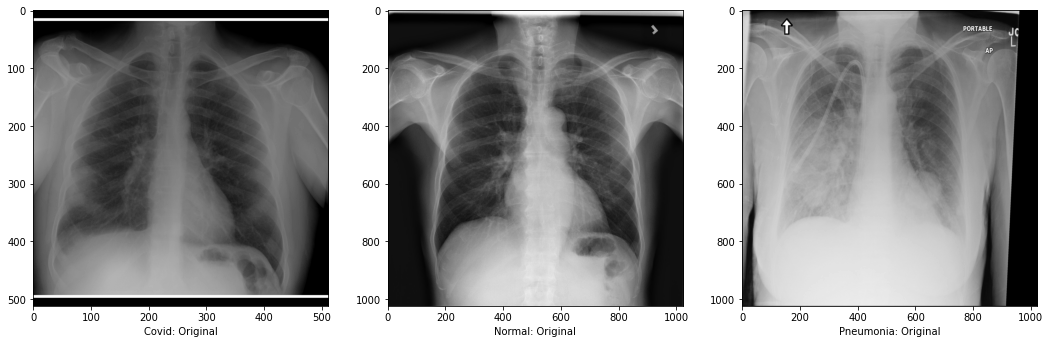

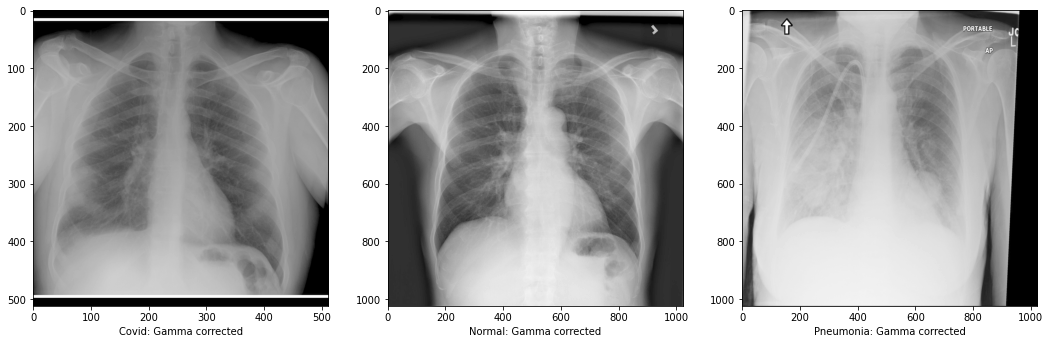

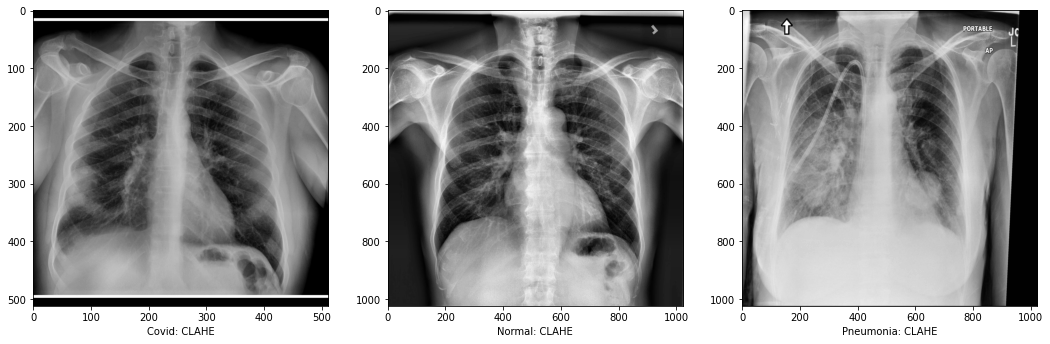

In [ ]:
#hide_input
fig = plt.figure(figsize = (18,10))
plt.subplot(1,3,1)
plt.imshow(np.array(image_1_cov), cmap = 'gray')
plt.xlabel('Covid: Original');
plt.subplot(1,3,2)
plt.imshow(np.array(image_2_normal), cmap = 'gray')
plt.xlabel('Normal: Original');
plt.subplot(1,3,3)
plt.imshow(np.array(image_3_pneumonia), cmap = 'gray')
plt.xlabel('Pneumonia: Original');

# Gamma Correction values = 0.6
plt.figure(figsize = (18,10))
plt.subplot(1,3,1)
plt.imshow(exposure.adjust_gamma(np.array(image_1_cov), gamma = 0.6), cmap = 'gray')
plt.xlabel('Covid: Gamma corrected')
plt.subplot(1,3,2)
plt.imshow(exposure.adjust_gamma(np.array(image_2_normal), gamma = 0.6), cmap = 'gray')
plt.xlabel('Normal: Gamma corrected')
plt.subplot(1,3,3)
plt.imshow(exposure.adjust_gamma(np.array(image_3_pneumonia), gamma = 0.6), cmap = 'gray')
plt.xlabel('Pneumonia: Gamma corrected');

#CLAHE

plt.figure(figsize = (18,10))
plt.subplot(1,3,1)
plt.imshow(exposure.equalize_adapthist(np.array(image_1_cov)), cmap = 'gray')
plt.xlabel('Covid: CLAHE')
plt.subplot(1,3,2)
plt.imshow(exposure.equalize_adapthist(np.array(image_2_normal)), cmap = 'gray')
plt.xlabel('Normal: CLAHE')
plt.subplot(1,3,3)
plt.imshow(exposure.equalize_adapthist(np.array(image_3_pneumonia)), cmap = 'gray')
plt.xlabel('Pneumonia: CLAHE');


## Augmentation 

The Data Augmentation technique is used to increase the amount of data by adding slightly changed inputs to the system. Data augmentation helps to improve the robustness of the model, act as a regularizer and reduce overfitting. We are applying three types of augmentation methods. Those are random rotation, horizontal flip, random perspective. The Deep CNN model used in this paper, takes the input image of constant size. As described in the data description section, the image size varies a lot. To overcome this problem the image size was chosen to be 224X224.

For Augmentation we will be using pytorch sub-library called torchvision. This library generally deals with computer vision tasks.

In [ ]:
import torchvision
from torchvision import transforms

Text(0.5, 1.0, 'Random Perspective')

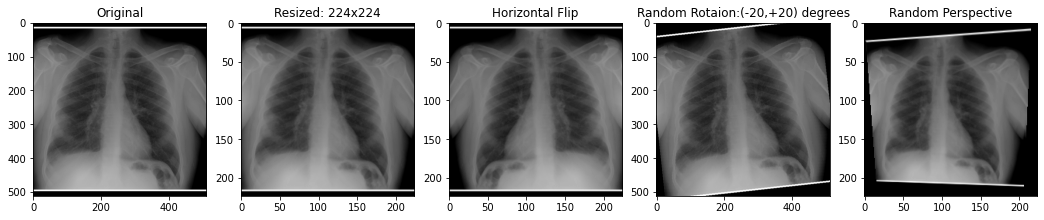

In [ ]:
#hide_input
plt.figure(figsize = (18,18))
plt.subplot(1,5,1)
plt.imshow(np.array(image_1_cov), cmap = 'gray')
plt.title("Original")
plt.subplot(1,5,2)
plt.imshow(np.array(transforms.Resize((224,224))(image_1_cov)), cmap = 'gray')
plt.title("Resized: 224x224")
plt.subplot(1,5,3)
plt.imshow(np.array(transforms.RandomHorizontalFlip(p=1)(transforms.Resize((224,224))(image_1_cov))), cmap = 'gray')
plt.title("Horizontal Flip")
plt.subplot(1,5,4)
plt.imshow(np.array(transforms.RandomRotation(20)(image_1_cov)), cmap = 'gray')
plt.title("Random Rotaion:(-20,+20) degrees")
plt.subplot(1,5,5)
plt.imshow(np.array(transforms.RandomPerspective(0.2)(transforms.Resize((224,224))(image_1_cov))), cmap = 'gray')
plt.title("Random Perspective")


## Z-Score Normalization

> Z-score normalization refers to the process of normalizing every value in a dataset such that the mean of all of the values is 0 and the standard deviation is 1.

$$ 
y = (x-\mu)/\sigma    
$$

$\mu$(Mean) and $\sigma$(Standard deviation) has to calculated for training set and then used to normalize the training set and later used while performing testing.

To calculate $\mu$(Mean) and $\sigma$(Standard deviation) we need to read every image in training set and then store the values. An efficient way perform this is done after defining pytorch dataset. We will come back to z-score normalization after defining pytorch dataset and dataloader.

# Model Training

Now after understanding the dataset and required pre-processing steps, we can now move forward to building our model. From your knowledge of Deep Learning, you must be knowing that deep learning models are nothing but matrix multiplication with added non-linearity. If models are made of matrix then we need input data in similar format. So our first step in training a model is to create a **Pytorch Dataset** that will convert our data(Images) to tensor.


In [32]:
#hide
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
#hide
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision 
from torchvision import transforms, models
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
from collections import OrderedDict
from skimage import exposure
from glob import glob
import torch.nn.functional as F
from torch import nn, optim

data_dir = {
    "train" : "./data/train/",
    "valid": "./data/validation/",
}

label_csv = {"train": './train_labels.csv',
            "valid": "./val_labels.csv"
            }
train_csv = pd.read_csv(label_csv['train'])
valid_csv = pd.read_csv(label_csv['valid'])

## Pytorch Dataset Class


A pytorch dataset class will have three functions:

1. __init__ : To initialize the variables that will be used in the class.
2. __len__ : This function returns the length of the dataset.
3. __getitem__: This function will return the tensor when we call the index of the dataet.

In [34]:
class covid_dataset(Dataset):
    
    def __init__(self, image_loc, label_loc, transform, data_type = 'train'):
        
        filenames = []
        for root, dirs, files in os.walk(image_loc):
            for file in files:
                if file.endswith('.jpg') == True or file.endswith('.png') == True :
                    filenames.append(file)
        if data_type == 'train' or data_type == 'valid':
            self.full_filenames = glob(image_loc+'*/*.*')
        else:
            self.full_filenames = glob(image_loc+'*.*')
        label_df = pd.read_csv(label_loc)
        label_df.set_index("0", inplace = True)
        self.labels = [label_df.loc[filename].values[0] for filename in filenames]
        self.transform = transform
        
        
    def __len__(self):
        return len(self.full_filenames)
    
    
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx]) 
        image = image.convert('RGB')
        image = self.transform(image)
        return image, self.labels[idx]
        

You can read more about Pytorch Custom Dataset [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

Lets test our pytorch dataset. It inputs image location, label location and transforms(Augmentation + tensor conversion). We will also look the shape and label of one example from dataset.

In [35]:
#collapse-output
train_data_1 = covid_dataset(image_loc = data_dir['train'],
                          label_loc = label_csv['train'],
                          transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()]),
                          data_type = 'train')
for x, y in train_data_1:
    print(x.shape)
    print(y)
    break

torch.Size([3, 256, 256])
2


The Pytoch dataset is working fine. Now lets define the Pytorch Dataloader. Pytorch Dataloader is mainly used to convert our dataset into batches. As weights of model are updated after data going through batches. This also shuffles our data.

In [36]:
#collapse-output
trainloader = DataLoader(train_data_1,batch_size = 64,shuffle = True)

for x, y in trainloader:
    print(x.shape)
    print(y)
    break

torch.Size([64, 3, 256, 256])
tensor([1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 2, 2, 2, 1, 2, 1, 0, 2,
        0, 2, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 2, 2, 1, 2, 0, 2, 0, 1, 2, 0, 0, 2, 2])


Z- Score mean calculations after defining dataset and dataloader class. I would highly suggest you watch this [video](https://www.youtube.com/watch?v=y6IEcEBRZks) to undertand how the following code works. Please also read this [blog](https://www.thoughtco.com/sum-of-squares-formula-shortcut-3126266) for mathematical understanding of mean calculation for datasets in batches. 

In [ ]:
#collapse-output
def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


mean, std = get_mean_std(trainloader)
print(mean)
print(std)

  0%|          | 0/281 [00:00<?, ?it/s]

tensor([0.5027, 0.5027, 0.5028])
tensor([0.2459, 0.2459, 0.2459])


Now to maintain simplicity and create a baseline model, we will using only few data augmentation. I encourage you to experiment more with this.  

In [54]:
#collapse-hide

data_transforms = {
    
    'train': transforms.Compose([
        transforms.Resize(size = (256,256)),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.RandomRotation((-20,20)),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2459, 0.2459, 0.2459])
        
    ]),
    
    'valid' : transforms.Compose([
        transforms.Resize(size = (224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2459, 0.2459, 0.2459])
    ])
    
    
}


Again we need to define train and validation dataset and there corresponding dataloader.

In [55]:
#collapse-hide
valid_data = covid_dataset(image_loc = data_dir['valid'],
                          label_loc = label_csv['valid'],
                          transform = data_transforms['valid'],
                          data_type = 'valid')

train_data = covid_dataset(image_loc = data_dir['train'],
                          label_loc = label_csv['train'],
                          transform = data_transforms['train'],
                          data_type = 'train')


trainloader = DataLoader(train_data,batch_size = 8,shuffle = True, num_workers = 2)
validloader = DataLoader(valid_data,batch_size = 16,shuffle = False, num_workers = 2)

## Defining Model

In [56]:
#hide
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In this blog my sole purpose is to show you how to develop a baseline for CXR classification. So we will use a basic model architecture, ResNet50. But I again encourage you to experiment with deeper and new architecture, such as 
- Resnet150
- DenseNet121
- EfficientNet(B0-B4)

In Pytorch models we can easily find these architecture.

In [57]:
resnet50 = models.resnet50(pretrained=True)

If you had noticed that we made, pretrained = True as one of the parameter. This means the model will use weights that it learnt while training from ImageNet Dataset. 

In [58]:
#collapse-output
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

One more thing to notice is the last layer of current ResNet50 model. Scroll down the output and you can see **out_features = 1000** Again as the original model was made for ImageNet dataset having 1000 classes, so that is the out_features or number of output nodes was set to 1000. For our task we have only 3 classes, so we need to modify this accordingly. Also we can change the final few layers, the classification head, with some other fully connected layers.

Also we will be using LogSoftmax as the final output activation function.

In [59]:
resnet50.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 3),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [60]:
#hide
for param in resnet50.parameters():
    param.require_grad = True
    
model = resnet50
model.to(device);

## Loss function, optimizers and Metric

Chossing Loss function is depended the output activation fundion we choosed. In our case we will be using Negative Log Likelihood loss [(NLL Loss)](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html). 
Please refer to the table for your use case. 


| Output Activation 	| Number of Outputs 	| Loss Function        	|
|-------------------	|-------------------	|----------------------	|
| None              	| 1                 	| nn.BCEWithLogitsLoss 	|
| Sigmoid           	| 1                 	| nn.BCELoss           	|
| None              	| Any(More than 1)  	| nn.CrossEntropyLoss  	|
| log_softmax       	| Any(More than 1)  	| nn.NLLLoss           	|

In [61]:
criterion = nn.NLLLoss()

We will be using ADAM optimizer for optimization with initial learning rate as 0.001. Along with the optimizer, we will be using a learning rate Scheduler. The purpose of learning rate scheduler is to decrease the learing rate when validation set loss is not reducing for better optimization. 

In [62]:
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)

**If you cant measure, you cant imaprove.** 
For mesuring the results, we will be using accuracy metric and will be ploting confusion matrix. 

In [63]:
#hide
import pandas as pd
import seaborn as sns

In [64]:
#collapse-hide
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred, dim =1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def calc_confusion_matrix(model, loader, device, nb_classes):
    confusion_matrix = np.zeros((nb_classes, nb_classes))
    with torch.no_grad():
        for i, (inputs, classes) in tqdm(enumerate(loader)):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes, preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix.astype(int)

In [65]:
#hide
def plot_confusion_matrix(confusion_matrix, validloader, path_save):
    plt.figure(figsize=(15,10))

    class_names = ['covid', 'normal', 'pneumonia']
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    try:
        plt.savefig(path_save)
    except:
        pass

## Training and Validation loop

For training purposes, normal pytorch training and validation loop is used. 

In [66]:
#hide
epochs = 30
valid_loss_min = np.Inf

In [ ]:
#collapse-hide
train_loss_hist = []
valid_loss_hist = []
train_acc_hist = []
valid_acc_hist = []


for i in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 
    
    
    model.train()
    
    for images,labels in tqdm(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        ps = model(images)
        loss = criterion(ps,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy(ps,labels)
        train_loss += loss.item()
        
    avg_train_acc = train_acc / len(trainloader)
    train_acc_hist.append(avg_train_acc)
    avg_train_loss = train_loss / len(trainloader)
    train_loss_hist.append(avg_train_loss)
        
    model.eval()
    with torch.no_grad():
        
        for images,labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            ps = model(images)
            loss = criterion(ps,labels)
            
            valid_acc += accuracy(ps,labels)
            valid_loss += loss.item()
            
            
        avg_valid_acc = valid_acc / len(validloader)
        valid_acc_hist.append(avg_valid_acc)
        avg_valid_loss = valid_loss / len(validloader)
        valid_loss_hist.append(avg_valid_loss)
        
        schedular.step(avg_valid_loss)
        
        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'Resnet50_5_epochs.pt')
            
            valid_loss_min = avg_valid_loss
            
            
    print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))


# Results

## Loss Curve

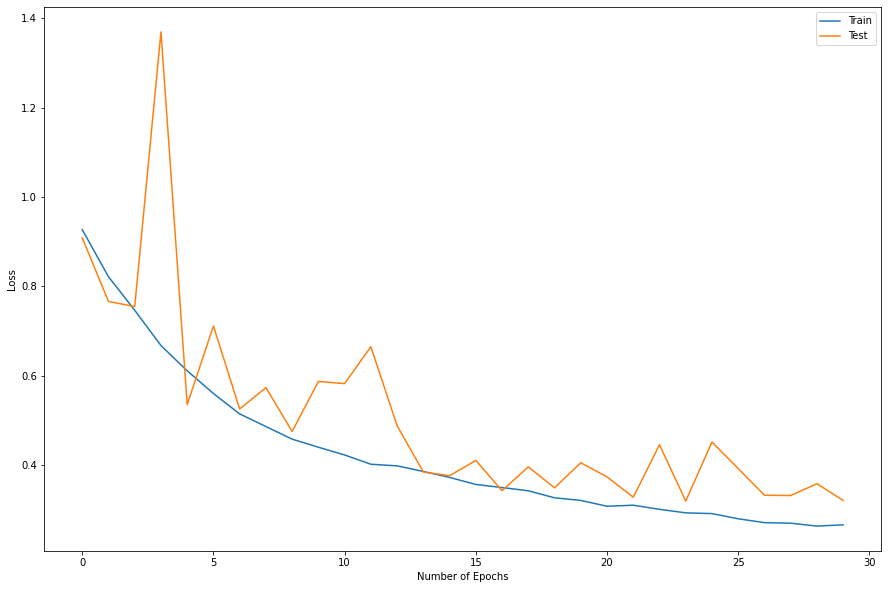

In [68]:
#hide_input
plt.figure(figsize=(15,10))
plt.plot(train_loss_hist, label = 'Train')
plt.plot(valid_loss_hist, label = 'Test')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

## Accuracy and Confusion Matrix

Text(0, 0.5, 'Accuracy')

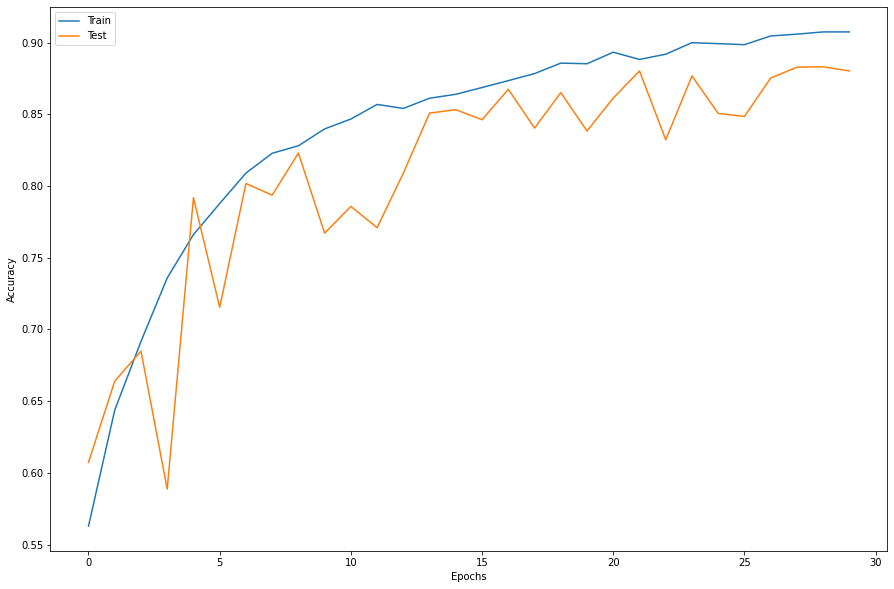

In [69]:
#hide_input
plt.figure(figsize=(15,10))
plt.plot(train_acc_hist, label = 'Train')
plt.plot(valid_acc_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Suggestions

This dataset is part of Chest XR COVID-19 detection challenge hosted on grandchallenge.org. I participated in that competition and got 3rd position. My baseline solution was similar to this blog. 
![](my_icons/leaderboard.png)


If you want to read my third position solution, please read the corresponding paper: 

WEIGHTED AVERAGE ENSEMBLE METHOD FOR CLASSIFICATION OF COVID-19 AND PNEUMONIA FROM CHEST X-RAYS 
by Akansh Maurya, Dr. Ganapathy Krishnamurthi

# References

- M. A. Akhloufi and M. Chetoui, Chest XR COVID-19 detection. https://cxr-covid19.grand-challenge.org/, 2021.
- Pytorch: https://pytorch.org/
- Monai: https://monai.io/
- PyTorch Computer Vision Cookbook by Michael Avendi

# About Me:
I am Akansh maurya, working as a post-bacc at Robert Bosch Center of Data Science and AI, Indian Institute of Technology(IIT), Madras. 

> <a href="https://twitter.com/akansh_maurya?ref_src=twsrc%5Etfw" class="twitter-follow-button" data-show-count="false">Follow @akansh_maurya</a><script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

Consider joining our Slack channel for discussion, tutorials, talks and, new research in Deep learning and Medical Imaging.